# GTEx Analysis

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import fisher_exact
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline

outdir = os.path.join(ciepy.root, 'output',
                      'gtex_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gtex_analysis')
cpy.makedir(private_outdir)

In [12]:
# Single tissue results.
fns = glob.glob('/publicdata/gtex_v6/*.snpgenes')
gtex_results = {}
for fn in fns:
    print(os.path.split(fn)[1][:-18])
    gtex_results[os.path.split(fn)[1][:-18]] = pd.read_table(fn, index_col=0,
                                                                 low_memory=False)
# for k in gtex_results.keys():
#     t = gtex_results[k]
#     t.Gen_ID = t.Gen_ID.apply(lambda x: x.split('.')[0])
#     gtex_results[k] = t
    
# # Single tissue expression matrices.
# fns = glob.glob('/publicdata/gtex_20151104/*.expr.txt')
# gtex_exp = {}
# for fn in fns:
#     gtex_exp[os.path.split(fn)[1].split('.')[0]] = pd.read_table(fn, index_col=0,
#                                                                 low_memory=False)
# for k in gtex_exp.keys():
#     t = gtex_exp[k]
#     t.index = [x.split('.')[0] for x in t.index]
#     gtex_exp[k] = t

Brain_Hippocampus
Nerve_Tibial
Brain_Cortex
Adrenal_Gland
Skin_Not_Sun_Exposed_Suprapubic
Brain_Cerebellum
Cells_Transformed_fibroblasts
Pituitary
Liver
Esophagus_Mucosa
Artery_Tibial
Brain_Cerebellar_Hemisphere
Colon_Transverse
Heart_Atrial_Appendage
Colon_Sigmoid
Artery_Aorta
Pancreas
Muscle_Skeletal
Artery_Coronary
Heart_Left_Ventricle
Esophagus_Gastroesophageal_Junction
Brain_Nucleus_accumbens_basal_ganglia
Brain_Hypothalamus
Ovary
Whole_Blood
Esophagus_Muscularis
Brain_Putamen_basal_ganglia
Adipose_Subcutaneous
Skin_Sun_Exposed_Lower_leg
Stomach
Adipose_Visceral_Omentum
Lung
Thyroid
Brain_Frontal_Cortex_BA9
Breast_Mammary_Tissue
Brain_Anterior_cingulate_cortex_BA24
Testis
Spleen
Prostate
Vagina
Brain_Caudate_basal_ganglia
Cells_EBV-transformed_lymphocytes
Uterus
Small_Intestine_Terminal_Ileum


In [40]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.index = [x.split('.')[0] for x in qvalues.index]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)
lead_vars_single.gene_id = lead_vars_single.gene_id.apply(lambda x: x.split('.')[0])
lead_vars_single.index = [x.split('.')[0] for x in lead_vars_single.index]

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
#encode_chip_seq = pd.read_table(fn, index_col=0)
sig = lead_vars[lead_vars.perm_sig == 1]

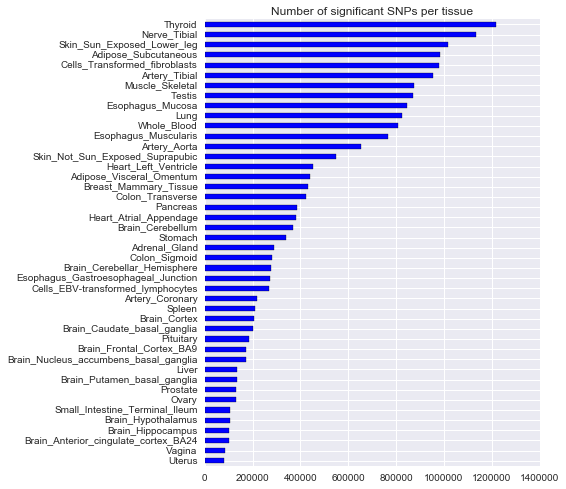

In [19]:
se = pd.Series([df.shape[0] for df in gtex_results.values()], 
               index=gtex_results.keys())
se.sort_values(inplace=True)
plt.figure(figsize=(6, 8))
ax = se.plot(kind='barh')
ax.set_title('Number of significant SNPs per tissue');

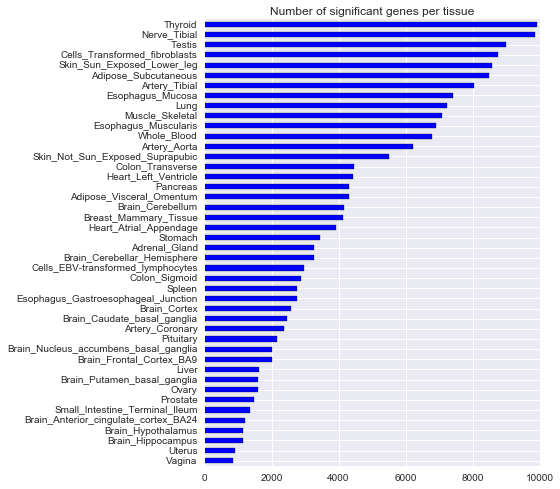

In [21]:
se = pd.Series([len(set(df.gene)) for df in gtex_results.values()], 
               index=gtex_results.keys())
se.sort_values(inplace=True)
plt.figure(figsize=(6, 8))
ax = se.plot(kind='barh')
ax.set_title('Number of significant genes per tissue');

From the supplement: "For a given tissue, genes having at least 0.1 RPKM in 2 or more individuals were retained."
All of the expression matrices only include genes that pass this filter. So I think they tested
all genes in their expression matrices for eQTLs.

I want to see how much my results overlap with theirs. First, I will 
just check for each single tissue how many of our significant genes
overlap. I can compute a $p$-value with a Fisher test.

Then I should test for individual genes to see if our effect is in the
same direction and whether we find similar SNVs.

In [9]:
for k in gtex_exp.keys():
    print(k, gtex_exp[k].shape[0], len(set(gtex_exp[k].index) & set(gene_info.index)))

('Thyroid', 30042, 0)
('Stomach', 26829, 0)
('Adipose_Subcutaneous', 27704, 0)
('Nerve_Tibial', 28891, 0)
('Esophagus_Mucosa', 26535, 0)
('Artery_Aorta', 25222, 0)
('Muscle_Skeletal', 24468, 0)
('Lung', 30097, 0)
('Heart_Left_Ventricle', 24116, 0)
('Artery_Tibial', 26270, 0)
('Whole_Blood', 25064, 0)
('Esophagus_Muscularis', 25753, 0)
('Skin_Sun_Exposed_Lower_leg', 29235, 0)


In [ ]:
pvalues = []
oddsratios = []
for k in gtex_exp.keys():
    edf = gtex_exp[k]
    sdf = gtex_results[k]
    common = set(qvalues.index) & set(edf.index)
    t = qvalues.ix[common]
    edf = edf.ix[common]
    my_sig = set(t[t.perm_sig == 1].index)
    my_not_sig = set(t[t.perm_sig == 0].index)
    gtex_sig = set(sdf.Gen_ID)
    gtex_not_sig = set(edf.index) - gtex_sig
    sig_sig = len(my_sig & gtex_sig)
    sig_not_sig = len(my_sig & gtex_not_sig)
    not_sig_sig = len(my_not_sig & gtex_sig)
    not_sig_not_sig = len(my_not_sig & gtex_not_sig)
    odds, p = fisher_exact([[sig_sig, sig_not_sig], [not_sig_sig, not_sig_not_sig]])
    pvalues.append(p)
    oddsratios.append(odds)
overlap = pd.DataFrame({'pvalue':pvalues, 'odds':oddsratios}, index=gtex_exp.keys())

In [11]:
overlap.pvalue

Thyroid                       1.436185e-165
Stomach                        4.271359e-88
Adipose_Subcutaneous          8.304488e-143
Nerve_Tibial                  3.772034e-141
Esophagus_Mucosa              1.460207e-157
Artery_Aorta                  3.997585e-109
Muscle_Skeletal               1.322435e-118
Lung                          2.333950e-151
Heart_Left_Ventricle          5.323792e-109
Artery_Tibial                 6.289060e-153
Whole_Blood                   7.565905e-106
Esophagus_Muscularis          4.388776e-155
Skin_Sun_Exposed_Lower_leg    3.072725e-137
Name: pvalue, dtype: float64

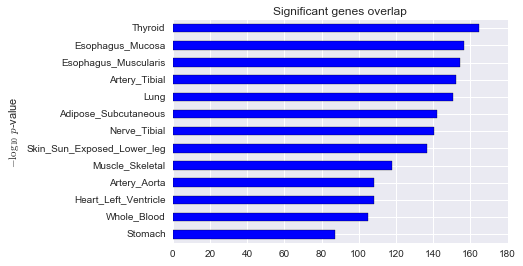

In [12]:
se = -np.log10(overlap.pvalue)
se.sort_values(inplace=True)
se.plot(kind='barh')
plt.ylabel('$-\log_{10}$ $p$-value')
plt.title('Significant genes overlap');

In [13]:
pvalues = []
oddsratios = []
for k in gtex_results.keys():
    res = gtex_results[k]
    # Drop indels and deletions since I haven't looked at those yet.
    res = res.ix[set([x for x in res.index if ((':D' not in x) and (':I' not in x))])]
    res.index = ('chr' + res.SNP_Chr.astype(str) + ':' + (res.SNP_Pos - 1).astype(str) + 
                 '-' + res.SNP_Pos.astype(str) + ':' + res.Gen_ID)
    gexp = gtex_exp[k]
    # Find genes that were both significant in my study and tested in GTEx.
    common = set(sig.gene_id) & set(gexp.index)
    common_sig = sig[sig.gene_id.apply(lambda x: x in common)]
    # Get GTEx results for my most significant SNVs.
    #inds = common_sig['location'] + ':' + common_sig.gene_id
    out = res.ix[common_sig.index, ['P_Val', 'Beta']]
    # Add GTEx results and make some new columns.
    common_sig['gtex_pvalue'] = out.P_Val.values
    common_sig['gtex_beta'] = out.Beta.values
    common_sig['gtex_pvalue_log'] = -np.log10(common_sig.gtex_pvalue)
    common_sig['pvalue_log'] = -np.log10(common_sig.pvalue)
    tdf = common_sig.dropna(subset=['gtex_beta'])
    # Check to see whether beta values agree.
    a = tdf['beta'] > 0
    b = tdf['gtex_beta'] > 0
    ctable = tdf[['beta', 'gtex_beta']].groupby([a,b]).count()['beta'].unstack()
    ctable = ctable.replace(np.nan, 0)
    odds, p = fisher_exact(ctable)
    pvalues.append(p)
    oddsratios.append(odds)
beta_agreement = pd.DataFrame({'pvalue':pvalues, 'odds':oddsratios}, index=gtex_exp.keys())

In [14]:
-np.log10(beta_agreement.pvalue)

Thyroid                              inf
Stomach                       196.120935
Adipose_Subcutaneous          272.814799
Nerve_Tibial                  320.658832
Esophagus_Mucosa                     inf
Artery_Aorta                  265.668138
Muscle_Skeletal                      inf
Lung                          235.482464
Heart_Left_Ventricle                 inf
Artery_Tibial                 243.923307
Whole_Blood                   297.598379
Esophagus_Muscularis          291.930074
Skin_Sun_Exposed_Lower_leg           inf
Name: pvalue, dtype: float64

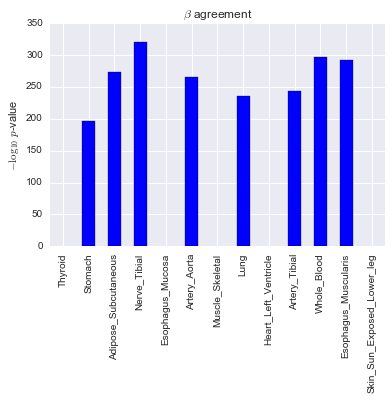

In [15]:
(-np.log10(beta_agreement.pvalue)).plot(kind='bar')
plt.ylabel('$-\log_{10}$ $p$-value')
plt.title(r'$\beta$ agreement');

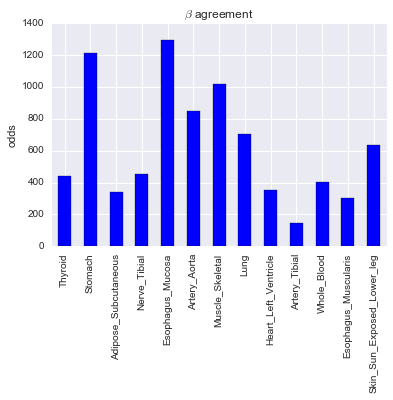

In [16]:
beta_agreement.odds.plot(kind='bar')
plt.ylabel('odds')
plt.title(r'$\beta$ agreement');

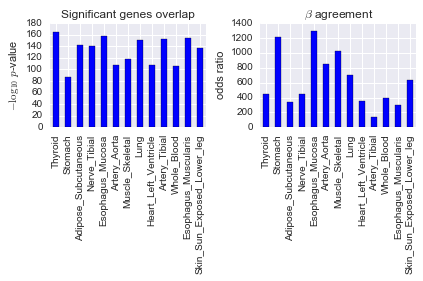

In [17]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
(-np.log10(overlap.pvalue)).plot(kind='bar', ax=ax)
ax.set_ylabel('$-\log_{10}$ $p$-value')
ax.set_title('Significant genes overlap');

ax = axs[1]
beta_agreement.odds.plot(kind='bar', ax=ax)
ax.set_ylabel('odds ratio')
ax.set_title(r'$\beta$ agreement');
plt.tight_layout()
fig.savefig(os.path.join(outdir, 'gtex_comp.pdf'))

## eQTL sharing

Given that a gene was an eQTL in iPSC, what is the probability 
that it was detected as an eQTL in a different tissue?

TODO: restrict to whether gene was tested. Plot as scatter with 
number of GTEx samples on axis.

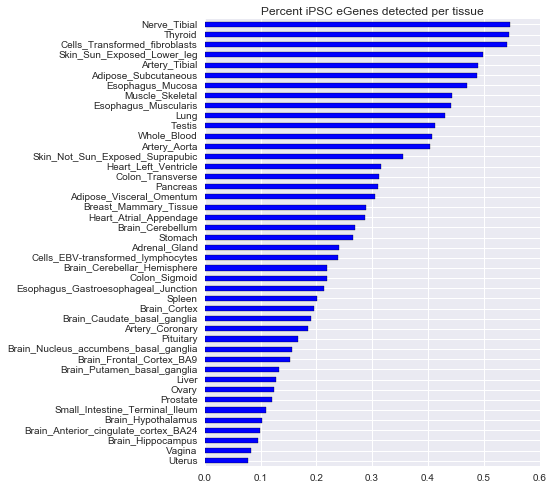

In [46]:
vals = []
n = float(len(set(sig.gene_id)))
for k in gtex_results.keys():
    vals.append(len(set(sig.gene_id) & set(gtex_results[k].gene)) / n)
    
se = pd.Series(vals, index=gtex_results.keys())
se.sort_values(inplace=True)
plt.figure(figsize=(6, 8))
ax = se.plot(kind='barh')
ax.set_title('Percent iPSC eGenes detected per tissue');